**<font size=4>Spam Email Classification**

**<font size=3>GOAL**
   
  - Determine whether a given email is spam or not.

**<font size=3>RESULT**
    
  - First stage: Build a model with the highest accuracy. Use lighGBM model get a 95% accuracy.  
    
    
  - Second stage: Build a cost sensitive prediction model.
      1. Use 10:1 cost ratio for different misclassification errors. 10:1 = false positive:false negative
      2. False positives (marking good mail as spam) are very undesirable. If we insist on zero false positives in the training/testing set, 20-25% of the spam passed through the filter. Lead to the lowest misclassification cost

**<font size=3>Dataset:**
    
    http://archive.ics.uci.edu/ml/datasets/Spambase

**<font size=3>Class Distribution:**
    
	Spam	  1813  (39.4%)
	Non-Spam  2788  (60.6%)

**<font size=3>Variable description**
    
SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)

- 48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) total number of words in e-mail.  A "word" in this case is anystring of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

  
- 6 continuous real [0,100] attributes of type char_freq_CHAR = percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

    
- 1 continuous real [1,...] attribute of type capital_run_length_average = average length of uninterrupted sequences of capital letters

    
- 1 continuous integer [1,...] attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters

    
- 1 continuous integer [1,...] attribute of type capital_run_length_total = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail
    
- 1 nominal {0,1} class attribute of type spam = denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

In [3]:
colnames=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our',
'word_freq_over','word_freq_remove','word_freq_internet','word_freq_order',
'word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report',
'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you',
'word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp',
'word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs',
'word_freq_telnet''word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology',
'word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
'word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table',
'word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!',
'char_freq_$','char_freq_#','wf','capital_run_length_average','capital_run_length_longest',
'capital_run_length_total','prediction']
df = pd.read_csv('spambase.data', names=colnames, index_col=False)

In [4]:
df['prediction'] = df['prediction'].astype('category')

# EDA

<AxesSubplot:>

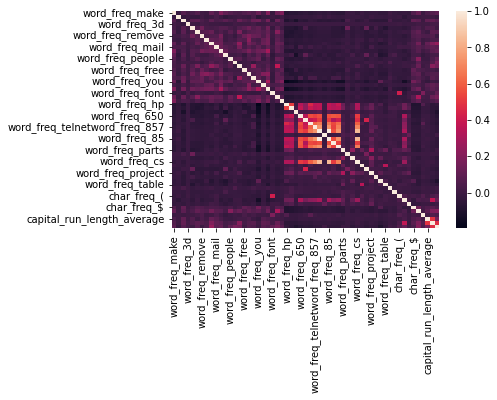

In [5]:
data_cor = df.corr()
sns.heatmap(data_cor)

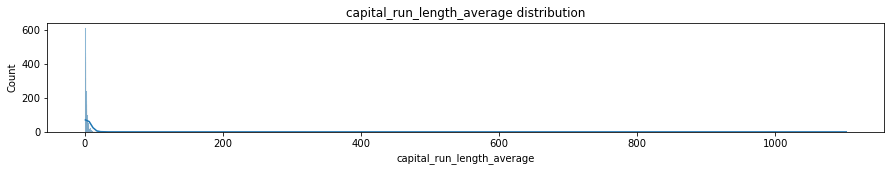

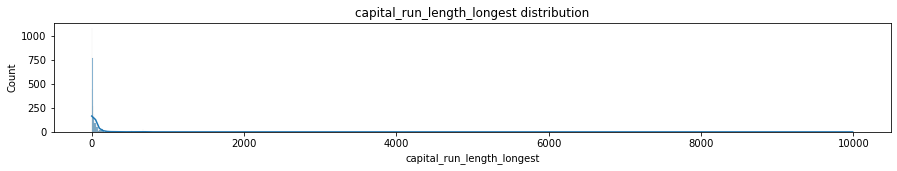

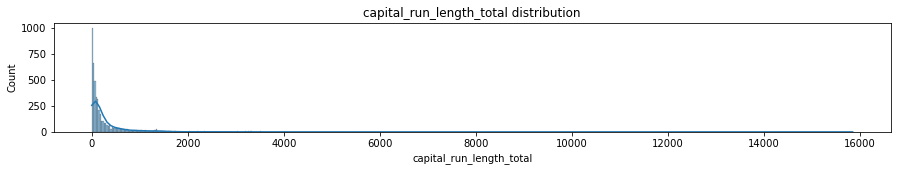

In [6]:
cols= ['capital_run_length_average','capital_run_length_longest','capital_run_length_total']
for col in cols:
    plt.figure(figsize=(15, 2))
    sns.histplot(df[col], kde=True)
    plt.title(col + " distribution")
    plt.show()

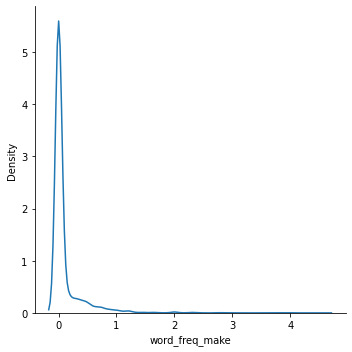

In [7]:
sns.displot(df['word_freq_make'], kind="kde")

# Data pre-processing

In [8]:
X = df.drop('prediction',axis=1)
y = df[['prediction']]

In [9]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Nested-CV to find the best model

In [10]:
i = 42
inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
scoring = 'accuracy'

In [11]:
dt = DecisionTreeClassifier()
dt_grid = {'max_depth':list(range(2,10)), 'min_samples_leaf':list(range(1,5))}
lr = LogisticRegression(solver='liblinear')
lr_grid = {'C':[0.1, 10, 1000]}
knn =  KNeighborsClassifier()
knn_grid = {'n_neighbors':list(range(2,5))}
svm = SVC()
svm_grid = {'kernel':['rbf'],'C':[1,10,100],'gamma':[.1,.5,1,5,10]} 
lgb = LGBMClassifier()
lgb_grid = {'max_depth':[-1],'num_leaves':[22, 31],'learning_rate':[0.05,0.1,0.3]}


def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)
NN_grid = {'activation':['relu','sigmoid'], 
           'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}

In [12]:
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring = scoring, cv=inner_cv)
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)
svm_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, scoring = scoring, cv=inner_cv)
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = scoring, cv=inner_cv)
NN_clf = GridSearchCV(estimator=NN, param_grid=NN_grid, scoring = scoring, cv=inner_cv)

In [13]:
dt_score = cross_val_score(dt_clf, X=X, y=y, cv=outer_cv)
lr_score = cross_val_score(lr_clf, X=X_scaled, y=y, cv=outer_cv)
knn_score = cross_val_score(knn_clf, X=X_scaled, y=y, cv=outer_cv)
svm_score = cross_val_score(svm_clf, X=X_scaled, y=y, cv=outer_cv)
lgb_score = cross_val_score(lgb_clf, X=X.values, y=y, cv=outer_cv)
NN_score = cross_val_score(NN_clf, X=X_scaled, y=y, cv=outer_cv)

2022-03-16 15:57:34.215099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 15:57:34.311013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
score = {}
score['dt'] = dt_score.mean()
score['lr'] = lr_score.mean()
score['knn'] = knn_score.mean()
score['svm'] = svm_score.mean()
score['lgb'] = lgb_score.mean()
score['NN'] = NN_score.mean()
score

{'dt': 0.9219740868054244,
 'lr': 0.9258856193102406,
 'knn': 0.8948067842707664,
 'svm': 0.935665017187323,
 'lgb': 0.952834963925509,
 'NN': 0.937403958750425}

Among all 6 models, LighGBM performs the best, which get a 95.3% accuracy on hold out data.

## Best model- LightGBM

After finding the best performed model using NestesCV, I final tune the model to get the best parameters.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
scaler=MinMaxScaler()
scaler=scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [17]:
from lightgbm import LGBMClassifier
params = {'max_depth':-1,'num_leaves':[22],'learning_rate':[0.1]}
lgb = LGBMClassifier(**params)
lgb.fit(X_train.values, y_train)
y_train_lgb = lgb.predict(X_train.values)
y_pred_lgb = lgb.predict(X_test.values)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('Training set score:', accuracy_score(y_train, y_train_lgb))
print('Testing set score:', accuracy_score(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

Training set score: 0.9956521739130435
Testing set score: 0.9594496741491673
[[779  25]
 [ 31 546]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       804
           1       0.96      0.95      0.95       577

    accuracy                           0.96      1381
   macro avg       0.96      0.96      0.96      1381
weighted avg       0.96      0.96      0.96      1381



I get a 99.6% accuracy on train data and 95.9% on test data.

AUC: 0.990


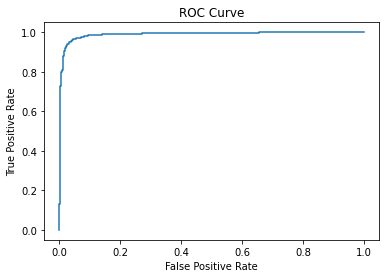

In [19]:
from sklearn import metrics
prob = lgb.predict_proba(X_test)[:, 1]

fpr, tpr, _ = metrics.roc_curve(y_test, prob, pos_label=1)
print('AUC: %2.3f' %metrics.auc(fpr, tpr))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC curve is closely to the top left, meaning that the model is good at capturing true positive.

The AUC is 0.99, meaning that there is a 99% chance that the model correctly predict ture positive before false positive.

# Cost sensitive models

Use 10:1 cost ratio for different misclassification errors.

In [20]:
from sklearn.metrics import fbeta_score, make_scorer
def loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = cm[0][1] * 10 + cm[1][0] * 1
    return cost

scoring1 = make_scorer(loss_func, greater_is_better= False)

In [21]:
i = 42
inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

In [22]:
dt = DecisionTreeClassifier()
dt_grid = {'max_depth':list(range(2,10)), 'min_samples_leaf':list(range(1,5))}
lr = LogisticRegression(solver='liblinear')
lr_grid = {'C':[0.1, 10, 1000]}
knn =  KNeighborsClassifier()
knn_grid = {'n_neighbors':list(range(2,5))}
svm = SVC()
svm_grid = {'kernel':['rbf'],'C':[1,10,100],'gamma':[.1,.5,1,5,10]} 
lgb = LGBMClassifier()
lgb_grid = {'max_depth':[-1],'num_leaves':[22, 31],'learning_rate':[0.05,0.1,0.3]}


def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)
NN_grid = {'activation':['relu','sigmoid'], 
           'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}

In [23]:
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring1, cv=inner_cv)
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring = scoring1, cv=inner_cv)
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring1, cv=inner_cv)
svm_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, scoring = scoring1, cv=inner_cv)
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = scoring1, cv=inner_cv)
NN_clf = GridSearchCV(estimator=NN, param_grid=NN_grid, scoring = scoring1, cv=inner_cv)

In [24]:
dt_score = cross_val_score(dt_clf, X=X, y=y, cv=outer_cv)
lr_score = cross_val_score(lr_clf, X=X_scaled, y=y, cv=outer_cv)
knn_score = cross_val_score(knn_clf, X=X_scaled, y=y, cv=outer_cv)
svm_score = cross_val_score(svm_clf, X=X_scaled, y=y, cv=outer_cv)
lgb_score = cross_val_score(lgb_clf, X=X.values, y=y, cv=outer_cv)
NN_score = cross_val_score(NN_clf, X=X_scaled, y=y, cv=outer_cv)

In [25]:
score_cost = {}
score_cost['dt'] = -dt_score.mean()
score_cost['lr'] = -lr_score.mean()
score_cost['knn'] = -knn_score.mean()
score_cost['svm'] = -svm_score.mean()
score_cost['lgb'] = -lgb_score.mean()
score_cost['NN'] = -NN_score.mean()
score_cost

{'dt': 363.5,
 'lr': 395.75,
 'knn': 415.0,
 'svm': 345.5,
 'lgb': 287.25,
 'NN': 389.25}

Among all, LightGBM performs best with the lowest cost.

## Best cost-sensitive model- LightGBM

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
scaler=MinMaxScaler()
scaler=scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [28]:
from lightgbm import LGBMClassifier
params = {'max_depth':-1,'num_leaves':[22],'learning_rate':[0.1]}
lgb = LGBMClassifier(**params)
lgb.fit(X_train.values, y_train)
#y_train_lgb = lgb.predict(X_train.values)
#y_pred_lgb = lgb.predict(X_test.values)

LGBMClassifier(learning_rate=[0.1], num_leaves=[22])

In [29]:
train_prob = lgb.predict_proba(X_train)[:, 1]
y_train_pred = [1 if prob > 0.95 else 0 for prob in np.ravel(train_prob)]

test_prob = lgb.predict_proba(X_test)[:, 1]
y_test_pred = [1 if prob > 0.95 else 0 for prob in np.ravel(test_prob)]

In [30]:
print('Training set score:', accuracy_score(y_train, y_train_pred))
print('Testing set score:', accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Training set score: 0.94472049689441
Testing set score: 0.9087617668356264
[[799   5]
 [121 456]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       804
           1       0.99      0.79      0.88       577

    accuracy                           0.91      1381
   macro avg       0.93      0.89      0.90      1381
weighted avg       0.92      0.91      0.91      1381



If I set the threadhold to 0.95, the average misclassification cost = (121+5*10)/1381 = 0.1238

AUC: 0.990


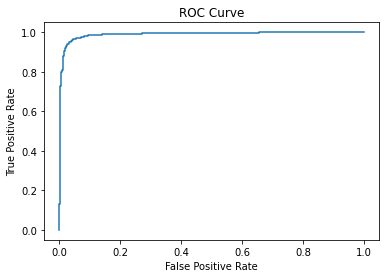

In [31]:
from sklearn import metrics
prob = lgb.predict_proba(X_test)[:, 1]

fpr, tpr, _ = metrics.roc_curve(y_test, prob,pos_label=1)
print('AUC: %2.3f' %metrics.auc(fpr, tpr))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC curve is closely to the top left, meaning that the model is good at capturing true positive.

The AUC is 0.99, meaning that there is a 99% chance that the model correctly predict ture positive before false positive.

# Conclusion

## First case: highest accuracy model

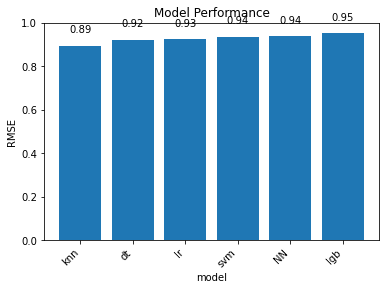

In [32]:
score_df = pd.DataFrame(list(score.items()), 
                               columns=['Model', 'RMSE']).sort_values('RMSE')

x = score_df['Model']
y = score_df['RMSE']

fig,ax = plt.subplots()
plt.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha='right')
plt.xlabel('model')
plt.ylabel('RMSE')
plt.title('Model Performance')

for a,b in zip(x,y):
    plt.text(a, b+0.05, '%2.2f' % b, ha='center', va= 'bottom',fontsize=10)

## Second case: lowest misclassification cost model

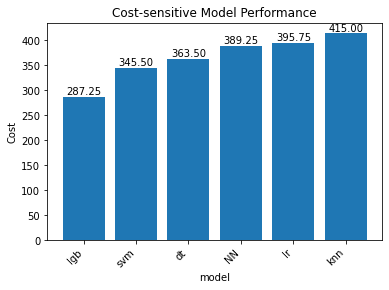

In [33]:
score_cost_df = pd.DataFrame(list(score_cost.items()), 
                               columns=['Model', 'Cost']).sort_values('Cost')
x = score_cost_df['Model']
y = score_cost_df['Cost']

fig,ax = plt.subplots()
plt.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha='right')
plt.xlabel('model')
plt.ylabel('Cost')
plt.title('Cost-sensitive Model Performance')

for a,b in zip(x,y):
    plt.text(a, b+0.05, '%2.2f' % b, ha='center', va= 'bottom',fontsize=10)

Among all models, including linear regression, decision tree, KNN, SYM classifier, LightGBM, and Neural Networ, LightGBM performs the best. So I pick LightGBM as my final model and further tune the model.
LightGBM has a few advantage.
1. It makes the best prediciton. It gets a highest accuracy and also the lowest cost in both models. 
2. LightGBM is more computational efficient comparing to Neural Network.
3. We can further interpret the model with feature importances.

When tuning the hyper-parameter, with num_leaves = 22 and learning_rate=0.1, the model gets a 99.6% accuracy on train data and 95.9% on test data.

Then, we take misclassification cost into account. Misclassifying a nonspam as spam will be more costly than classifying a spam as nonspam. Therefore, we set the cost as 10:1. Considering the cost, if I set the threadhold to 0.95, the average misclassification cost = (125+5*10)/1381 = 0.123.

Overall, LightGBM, as a emsembling tree model, is good at predicting spam.